# 1D Quantum spin chains

## Set-up environment

Install `blackjax` if not already available. Note that `blackjax` is not available by default in Google Colab where this notebook was tested, therefore this step is necessary. Otherwise, it may be commented out.

In [1]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 12.7 MB/s eta 0:00:00


Import all the required libraries at once.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
from datetime import date
import jax
import jax.numpy as jnp
import blackjax

## 1D Quantum spin chains
[Gosset and Bravyi](https://arxiv.org/abs/1503.04035) parameterize all 2-local (acting on two sites) 1D quantum spin Hamiltonians $H$ of the form $H = \sum_{i} h_i,$ for
- spin-1/2 (qubits)
- $h_i$ are the same upto the location of sites for different $i$ and
- $h_i$ are rank 1 projectors

in terms of two parameters $\theta$ (i.e. what that article calls $\theta_2 - \theta_1$) and $p.$ What is special about these Hamiltonians, is that Gosset and Bravyi were able to show when such Hamiltonians are gapped or gapless.

**Defition:** A Hamiltonian is gapped if the difference between its lowest and second lowest eigenvalue tends to a constant as the system size (number of spin 1/2) tends to infinity. Similarly, a Hamiltonian is gapless if the difference between its lowest and second lowest eigenvalue tends to 0 as the system size (number of spin 1/2) tends to infinity.

**Significance:** In Physics, on the one hand, gapless spin Hamiltonians show critical phenomena and phase transitions, i.e. long range correlated behaviour. On the other hand, gapped spin Hamiltonians (in 1D) can be efficiently simulated on classical computers, and exhibit short range correlations.

**Question:** All of the above is effectively known for the case of 0 temperature. We wonder what happens to a physical quantity that could potentially show phase transition behaviour (e.g. net magnetization) at finite temperature? In other words, how does gapped/gapless-ness of the spin Hamiltonian manifest itself in net magnetization at finite temperature? *In particular, for 1D, open boundary condition spin 1/2 chain, does net magnetization at finite temperature exhibit exotic behavior as we tune the parameter $p$ such that the Hamiltonian goes from being gapped to being gapless?*

## Problem class
We define a class with the relevant parameters whose names are self explanatory---`theta`, `p`, inverse temperature `beta`---for the problem. We build the local term of the Hamiltonian in accordance to the article inside the `self.__init__()` method. We define a `self.cost()` method that computes the expectation value of the Hamiltonian with a proposed quantum state. Note that we restrict ourselves to only completely separale product states, which is a major simplification but allows us to scale up the number of sites without suffering the curse of dimensionality.

In [3]:
class GossetBravyiSpinChain:
  def __init__(self, number_spins, theta, p, beta=1.):
    self.number_spins = number_spins
    self.theta = theta
    self.p = p
    self.beta = beta
    self.rotation = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    local_hamiltonian_projector = np.kron(np.eye(2), self.rotation) @ ((np.array([[np.sqrt(1 - p), 0, 0, np.sqrt(p)]])).T)
    self.local_hamiltonian = local_hamiltonian_projector @ (local_hamiltonian_projector.T)

  def cost(self, data):
    @jax.jit
    def qubit_states(data):
      cc = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      cs = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      sc = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      ss = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      return jnp.array([cc, cs, sc, ss], dtype=jnp.float32)
    qs = qubit_states(data)
    return_cost = jnp.trace((qs.T) @ (self.local_hamiltonian @ qs))
    return - self.beta * return_cost


## Sampler class
This is identical to that from soft sphere packing phase transition example. We borrow and adapt the explanation from that example jupyter notebook. Most importantly, it is not obvious that a Hamiltonian Monte Carlo sampler will be able to sample the energy landscape effectively because it is not clear if the gradients of the energy with respect to the parameters that specify the proposal product states are even well defined. This criticism was absent for the case of soft spheres, because in that case, the gradients of the energy were clearly related to the classical mechanical momentum of the soft spheres.

Following is the Hamiltonian Monte Carlo sampling algorithm from `blackjax`. Although functions are provided in that package, we put it together in one coherent class whose interface is easy to use. User may simply provide an instance of the problem class (in our case, an instance of `GossetBravyiSpinChain`) and an initial "position" (a quantum product state) from the correct configuration space (subset of the Hilbert space containing only completely separable product states). Other options that a user may set are the options to "warmup" the sampler and if so then the number of steps (time) for which to "warmup". `warmup=True` allows the sampler to choose parameters---maximum `step_size` to move in the configuration space, and the inertia of the points to resist change, given by the `inverse_mass_matrix`---automatically. Otherwise the user needs to specify these parameters later when calling the `run` method of this class to generate samples.

In [4]:
# global constants for sampling algorithm
DEFAULT_WARMUP_TIME = 100
DEFAULT_STEP_SIZE = 0.005 * jnp.pi

class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_time=DEFAULT_WARMUP_TIME):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_time)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, inverse_mass_matrix, step_size=DEFAULT_STEP_SIZE):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

## Example
### Choice of parameters

Below we provide one example choice of parameters for which we recover a finite temperature phase transition in the net magnetization. We consider a 50 spin-1/2 chain, with $\theta = 2 \pi / 5,$ random initial product state, a unbiased inverse mass matrix and an empirically determined step size.

In [5]:
number_spins = 50
theta = 2. * np.pi / 5.
run_time = 1000

np.random.seed(0)
initial_data = 2 * np.pi * np.random.rand(number_spins)
initial_position = {"data": initial_data}

inverse_mass_matrix = np.ones(len(initial_position.keys()))
step_size = 0.005 * jnp.pi

### Generate samples and compute net magnetization
We vary $p$ from 0 to 0.5 with a resolution of 101 including the end points. We compute the net magnetization by subtracting the probability a spin is pointed down from the probability it is pointing up for each spin in the chain and for each sample (for a total of `run_time` number of samples). We save the net magnetization for each value of `p` in `magnetization_list`.

In [6]:
magnetization_list = list()
plist = np.linspace(0, 0.5, 101)
sum_time = 0
start_time = t.time()
for p in plist:
  gbsc = GossetBravyiSpinChain(number_spins=number_spins, theta=theta, p=p, beta=128)
  nwa = NutsWindowAdapt(gbsc, initial_position, warmup=False)
  history = nwa.run(run_time=run_time, inverse_mass_matrix=inverse_mass_matrix, step_size=step_size)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']
  magnetization_list_item = np.sum(np.cos(history.copy()) ** 2 - np.sin(history.copy()) ** 2, axis=1) / number_spins
  magnetization_list.append(magnetization_list_item)
  print("\r p: " + format(np.round(p, 2), '.2f') + ", time elapsed: " + format(np.round(t.time() - start_time, 4), '.4f') + "s", end='')

 p: 0.50, time elapsed: 785.0951s

### Plots
We find the minimum and maximum value in the `magnetization_list` in order to set the limits of the histogram in the plot that comes next.

In [7]:
magnetization_list = np.array(magnetization_list)
print(np.min(np.reshape(magnetization_list, [-1])), np.max(np.reshape(magnetization_list, [-1])))

0.012501239 0.85467017


In the plot on the left, we depict a histogram constructed from all samples (total of `run_time`) net magnetization for each value of `p` with 0 < `p` < 0.2 in blue to black and 0.2 < `p` < 0.5 in black to red. In the plot on the right, we plot the standard deviation of each histogram on the left hand side plot, with the corresponding color scheme.

In the right hand side plot, the phase transition in net magnetization as measured by product state samples with an order parameter of `p` is apparent. At the critical `p` the standard deviation in the net magnetization diverges, which is indicative of the long range correlations of the spins.

This result is non-trivial in many ways,
- we constrained the Hilbert space to a subset of product states
- we sample used Hamiltonian Monte Carlo, which makes use of gradient information of the energy function, which, a priori, does not have a clear interpretation as "momentum" in the case of soft spheres
- a priori, we do not know if a finite temperature cross over from gapped to gapless phase of the Hamiltonian show leave any signature in the net magnetization

All in all, we used `blackjax` sampler on a quantum spin Hamiltonian problem, explored a tiny subset of the Hilbert space at finite temperature and observed a non-trivial behaviour of the net magnetization.

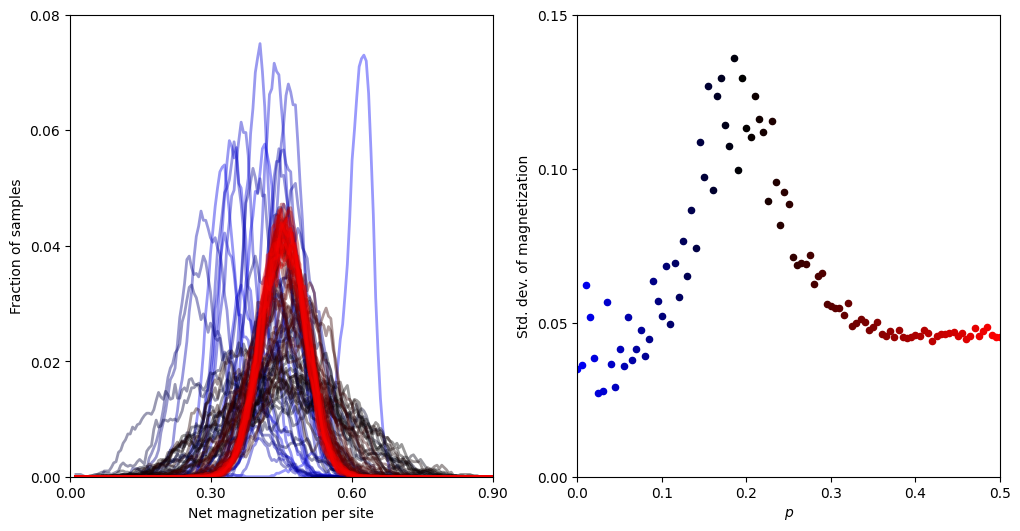

In [11]:
# plotting constants
color='black'
alpha=0.4
linewidth=2
bins = np.linspace(0, 1, 200)

# plotting data
xaxis = (bins[1:] + bins[:-1])/2
window = 5
average_xaxis = [np.mean(xaxis[i : i + window]) for i in range(len(xaxis) - window)]
size=20
maxstd = 0

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i in range(len(magnetization_list)):
  histogram_data, bins = np.histogram(magnetization_list[i], bins=bins)
  average_histogram_data = [np.mean(histogram_data[i : i + window]) for i in range(len(histogram_data) - window)]
  average_histogram_data = np.array(average_histogram_data)
  if maxstd < np.std(magnetization_list[i]):
    maxstd = np.std(magnetization_list[i])
  if plist[i] < 0.2:
    color = [0, 0, 1 - (i + 1) / len(plist[plist < 0.2])]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(magnetization_list[i])], size, color=color)
  else:
    color = [(i + 1 - len(plist[plist < 0.2])) / len(plist[plist >= 0.2]), 0, 0]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(magnetization_list[i])], size, color=color)

# plot formatting
ax[0].set_xticks(np.linspace(0, 0.9, 4))
ax[0].set_xticklabels([format(i, '.2f') for i in np.linspace(0, 0.9, 4)])
ax[0].set_xlim([0, 0.9])
ax[0].set_xlabel("Net magnetization per site")
ax[0].set_yticks(np.linspace(0, 80, 5))
ax[0].set_yticklabels([format(i / run_time, '.2f') for i in np.linspace(0, 80, 5)])
ax[0].set_ylim([0, 80])
ax[0].set_ylabel("Fraction of samples")

ax[1].set_xticks(np.linspace(0, 0.5, 6))
ax[1].set_xticklabels([format(i, '.1f') for i in np.linspace(0, 0.5, 6)])
ax[1].set_xlim([0, 0.5])
ax[1].set_xlabel(r"$p$")
ax[1].set_yticks(np.linspace(0, 0.15, 4))
ax[1].set_yticklabels([format(i, '.2f') for i in np.linspace(0, 0.15, 4)])
ax[1].set_ylim([0, 0.15])
ax[1].set_ylabel("Std. dev. of magnetization")
plt.show()